In [881]:
# Import all libararies and methods required for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score
from numpy import mean, std
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
import joblib
import os
import shutil
import statsmodels.api as sm

In [882]:
!ls

Heart_Disease_Research.numbers
Heart_Predict_V7.ipynb
Pranav_SC_Research_Contract.pdf
Pranav_Signed_Research_Contract.pdf
Pranav_Varanasi_SDS379R_Heart_Predict_Final.ipynb
Pranav_Varanasi_SDS479R_Research_Proposal.pdf
cleaned_frames
cleve.mod
cleveland.xlsx
heart-disease.names
heart_statlog_cleveland_hungary_final.csv
hungarian.xlsx
partial_frames
switzerland.xlsx
veterans.xlsx


In [883]:
# Method Section

# Read in input files to data frames
# Code sourced from https://www.geeksforgeeks.org/working-with-excel-files-using-pandas/
def readData():
    data_dict = {}
    for file in os.listdir(os.getcwd()):
        filename = os.fsdecode(file)
        file_str = str(filename)
        dot_index = file_str.find('.')

        # Remove extension from file name
        data_name = file_str[:dot_index]

        # Don't read extraneous files like .DSTORE
        # Keep all excel sheets closed to avoid "excel file format" error
        if filename.endswith(".xlsx"): 
            df = pd.read_excel(filename, na_values='?')
            # Ensure all columns are of numeric type
            df[df.columns] = df[df.columns].apply(pd.to_numeric, errors='coerce', axis=1)
            #print(df.dtypes)

            # Convert all negative data to invalid nan value
            column_labels = []
            for col in df.columns:
                df[col][df[col] < 0] = np.nan
                column_labels.append(col.lower())

            # Change column names to lowercase
            df.columns = column_labels 
            df.head()
            print('Dataset: ', data_name)
            print(df)

            # Save frame to data frame dictionary indexed by "veterans", "cleveland", etc
            data_dict[data_name] = df
    
    return data_dict

# Print out mean, median, summary statistics for each data frame
def printSummaryStats(data_dict):
    for frame in data_dict:
        print(frame)
        print(data_dict[frame].describe())
        print('\n\n')

# Calculate the missing value percent for each column in frame
# Code sourced from https://www.analyticsvidhya.com/blog/2021/06/how-to-clean-data-in-python-for-machine-learning/ 
def calcMissingPercent(data_dict):
    for frame in data_dict:
        print("DF Name: ", frame)
        current_df = data_dict[frame]
        for col in current_df.columns:
            # isnull takes into account NaN AND None data types
            percent = np.mean(current_df[col].isnull())
            print('{} - {}%'.format(col, round(percent * 100)))
        print('\n\n')

# Apply custom logic to clean out invalid values based on percent of missing data
def cleanInvalidData(data_dict):
    for frame in data_dict:
        current_df = data_dict[frame]
        for col in current_df.columns:
            percent = np.mean(current_df[col].isnull())
            # Clean invalid data columns (e.g. negatives)   
            # Drop columns where greater than 50% of data is missing or invalid
            if percent > 0.50:
                current_df = current_df.drop([col], axis = 1)
            # Fill NaN values with median for columns with less than 50% of data present
            # Use MEDIAN instead of MEAN because of discrete values in data (e.g. 0, 1, 2) for slope
            else:
                current_df[col] = current_df[col].fillna(method = 'ffill')
        
        data_dict[frame] = current_df

    return data_dict

# Create custom logic to specifiy range of valid values per variable
def cleanColumnData(data_dict):
    
    # Iterate through each frame's column and check each value is valid, drop invalid values
    for frame in data_dict:
        current_df = data_dict[frame]
        for col in current_df.columns:
            for i in range (0, len(current_df[col].values)):
                val = current_df[col][i]

                if col == 'age' and val <= 0:
                    current_df[col][i] = None
                elif col == 'sex' and (val != 0 and val != 1):
                    current_df[col][i] = None
                if col == 'chestpain' and (val != 1 and val != 2 and val != 3 and val != 4):
                    current_df[col][i] = None
                if col == 'restbp' and val <= 0:
                    current_df[col][i] = None
                if col == 'cholesterol' and val <= 0:
                    current_df[col][i] = None
                if col == 'fbs' and (val != 0 and val != 1):
                    current_df[col][i] = None
                if col == 'restecg' and (val != 0 and val != 1 and val != 2):
                    current_df[col][i] = None
                if col == 'maxhr' and val <= 0:
                    current_df[col][i] = None
                if col == 'exerciseang' and (val != 0 and val != 1):
                    current_df[col][i] = None
                if col == 'oldpeak' and val < 0:
                    current_df[col][i] = None
                if col == 'slope' and (val != 1 and val != 2 and val != 3):
                    current_df[col][i] = None
                if col == 'vesselscolored' and (val != 0 and val != 1 and val != 2 and val != 3):
                    current_df[col][i] = None
                if col == 'thal' and (val != 3 and val != 6 and val != 7):
                    current_df[col][i] = None
                if col == 'class' and (val != 0 and val != 1 and val != 2 and val != 3 and val != 4):
                    current_df[col][i] = None
                
        # Save newly cleaned frames back to dictionary
        data_dict[frame] = current_df

    return data_dict


# Generate correlation heat map for all frames in dictionary
# Code sourced from https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
def generateHeatMap(data_dict):
    frameCount = 0
    # Iterate through frames and print correlation map per frame
    for frame in data_dict:
        current_df = data_dict[frame]
        corr = current_df.corr()
        print(corr)
        plt.figure(frameCount)
        sns.heatmap(corr, 
                 xticklabels=corr.columns, 
                 yticklabels=corr.columns)
        plt.title(frame, fontsize =12)
        frameCount+=1

# Save partially cleaned data frames (keep invalid values) to file directory
# Code sourced from https://www.geeksforgeeks.org/exporting-a-pandas-dataframe-to-an-excel-file/
def save_partial_to_excel(df_name, input_df):
    os.makedirs('partial_frames', exist_ok=True)   
    path_name = 'partial_frames/partial_' + df_name + '.xlsx'
    input_df.to_excel(path_name, encoding='utf8', index = False)  
    
# Save fully cleaned data frames to file directory
# Code sourced from https://www.geeksforgeeks.org/exporting-a-pandas-dataframe-to-an-excel-file/
def save_df_to_excel(df_name, input_df):
    os.makedirs('cleaned_frames', exist_ok=True)   
    path_name = 'cleaned_frames/cleaned_' + df_name + '.xlsx'
    input_df.to_excel(path_name, encoding='utf8', index = False)  

# Plot the significance of each feature variable in a trained model
# Code sourced from https://towardsdatascience.com/3-essential-ways-to-calculate-feature-importance-in-python-2f9149592155
def plotPredictors(input_x, trained_model):
    
    # Create dataframe using list of features and the trained coefficients returned from model
    predictors = pd.DataFrame(data={
    'Variable': input_x.columns,
    'Significance': trained_model.coef_[0]
    })

    predictors = predictors.sort_values(by='Significance', ascending=False)

    # Show barplot of feature significances
    plt.bar(x=predictors['Variable'], height=predictors['Significance'], color='#087E8B')
    plt.title('Feature significances from coefficients', size=20)
    plt.xticks(rotation='vertical')
    plt.show()

In [884]:
# Data Cleaning Section:

In [885]:
# Save files to stored_frames dictionary
stored_frames = readData()        

Dataset:  veterans
      age  sex  chestpain  restbp  cholesterol  fbs  restecg  maxhr  \
0    63.0  1.0        4.0   140.0        260.0  0.0      1.0  112.0   
1     NaN  NaN        NaN     NaN          NaN  NaN      NaN    NaN   
2    44.0  1.0        4.0   130.0        209.0  0.0      1.0  127.0   
3    60.0  1.0        4.0   132.0        218.0  0.0      1.0  140.0   
4    55.0  1.0        4.0   142.0        228.0  0.0      1.0  149.0   
..    ...  ...        ...     ...          ...  ...      ...    ...   
196  54.0  0.0        4.0   127.0        333.0  1.0      1.0  154.0   
197  62.0  1.0        1.0     NaN        139.0  0.0      1.0    NaN   
198  55.0  1.0        4.0   122.0        223.0  1.0      1.0  100.0   
199  58.0  1.0        4.0     NaN        385.0  1.0      2.0    NaN   
200  62.0  1.0        2.0   120.0        254.0  0.0      2.0   93.0   

     exerciseang  oldpeak  slope  vesselscolored  thal  class  
0            1.0      3.0    2.0             NaN   NaN    2.0  


In [886]:
# Check for invalid data on a per-column basis (e.g. rest bp should never be 0)
printSummaryStats(stored_frames)

veterans
              age         sex   chestpain      restbp  cholesterol  \
count  200.000000  200.000000  200.000000  144.000000   193.000000   
mean    59.350000    0.970000    3.505000  133.763889   178.746114   
std      7.811697    0.171015    0.795701   21.537733   114.035232   
min     35.000000    0.000000    1.000000    0.000000     0.000000   
25%     55.000000    1.000000    3.000000  120.000000     0.000000   
50%     60.000000    1.000000    4.000000  130.000000   216.000000   
75%     64.000000    1.000000    4.000000  147.000000   258.000000   
max     77.000000    1.000000    4.000000  190.000000   458.000000   

              fbs     restecg       maxhr  exerciseang     oldpeak      slope  \
count  193.000000  200.000000  147.000000   147.000000  143.000000  98.000000   
mean     0.352332    0.735000  122.795918     0.646259    1.333566   2.132653   
std      0.478939    0.683455   21.990328     0.479765    1.099484   0.667937   
min      0.000000    0.000000   69.0

In [887]:
# Create None holes for values that are in an invalid range
cleanColumnData(stored_frames)

{'veterans':       age  sex  chestpain  restbp  cholesterol  fbs  restecg  maxhr  \
 0    63.0  1.0        4.0   140.0        260.0  0.0      1.0  112.0   
 1     NaN  NaN        NaN     NaN          NaN  NaN      NaN    NaN   
 2    44.0  1.0        4.0   130.0        209.0  0.0      1.0  127.0   
 3    60.0  1.0        4.0   132.0        218.0  0.0      1.0  140.0   
 4    55.0  1.0        4.0   142.0        228.0  0.0      1.0  149.0   
 ..    ...  ...        ...     ...          ...  ...      ...    ...   
 196  54.0  0.0        4.0   127.0        333.0  1.0      1.0  154.0   
 197  62.0  1.0        1.0     NaN        139.0  0.0      1.0    NaN   
 198  55.0  1.0        4.0   122.0        223.0  1.0      1.0  100.0   
 199  58.0  1.0        4.0     NaN        385.0  1.0      2.0    NaN   
 200  62.0  1.0        2.0   120.0        254.0  0.0      2.0   93.0   
 
      exerciseang  oldpeak  slope  vesselscolored  thal  class  
 0            1.0      3.0    2.0             NaN   NaN  

In [888]:
# Print percent of missing data for each column in frames
calcMissingPercent(stored_frames)

DF Name:  veterans
age - 0%
sex - 0%
chestpain - 0%
restbp - 29%
cholesterol - 28%
fbs - 4%
restecg - 0%
maxhr - 27%
exerciseang - 27%
oldpeak - 29%
slope - 51%
vesselscolored - 99%
thal - 83%
class - 0%



DF Name:  cleveland
age - 0%
sex - 0%
chestpain - 0%
restbp - 0%
cholesterol - 0%
fbs - 0%
restecg - 0%
maxhr - 0%
exerciseang - 0%
oldpeak - 0%
slope - 0%
vesselscolored - 1%
thal - 1%
class - 0%



DF Name:  switzerland
age - 0%
sex - 0%
chestpain - 0%
restbp - 2%
cholesterol - 100%
fbs - 61%
restecg - 1%
maxhr - 1%
exerciseang - 1%
oldpeak - 14%
slope - 14%
vesselscolored - 96%
thal - 42%
class - 0%



DF Name:  hungarian
age - 0%
sex - 0%
chestpain - 0%
restbp - 1%
cholesterol - 8%
fbs - 3%
restecg - 1%
maxhr - 1%
exerciseang - 1%
oldpeak - 0%
slope - 65%
vesselscolored - 99%
thal - 91%
class - 0%





In [889]:
# Remove all existing files in directory
if os.path.isdir('partial_frames'):
    shutil.rmtree('partial_frames')

# Save cleaned frames to csv files
for frame in stored_frames:
    save_partial_to_excel(frame, stored_frames[frame])

# Clean frames as per custom logic to eliminate > 50% missing values and forward-fill the rest
stored_frames = cleanInvalidData(stored_frames)

# Re-calculate the percent of missing data after cleaning
calcMissingPercent(stored_frames)

# Remove all existing files in directory
if os.path.isdir('cleaned_frames'):
    shutil.rmtree('cleaned_frames')

# Save cleaned frames to csv files
for frame in stored_frames:
    save_df_to_excel(frame, stored_frames[frame])

DF Name:  veterans
age - 0%
sex - 0%
chestpain - 0%
restbp - 0%
cholesterol - 0%
fbs - 0%
restecg - 0%
maxhr - 0%
exerciseang - 0%
oldpeak - 0%
class - 0%



DF Name:  cleveland
age - 0%
sex - 0%
chestpain - 0%
restbp - 0%
cholesterol - 0%
fbs - 0%
restecg - 0%
maxhr - 0%
exerciseang - 0%
oldpeak - 0%
slope - 0%
vesselscolored - 0%
thal - 0%
class - 0%



DF Name:  switzerland
age - 0%
sex - 0%
chestpain - 0%
restbp - 0%
restecg - 0%
maxhr - 0%
exerciseang - 0%
oldpeak - 0%
slope - 0%
thal - 2%
class - 0%



DF Name:  hungarian
age - 0%
sex - 0%
chestpain - 0%
restbp - 0%
cholesterol - 0%
fbs - 0%
restecg - 0%
maxhr - 0%
exerciseang - 0%
oldpeak - 0%
class - 0%





In [890]:
# Add column showing which dataset data is coming from
for frame in stored_frames:
    current_frame = stored_frames[frame]
    current_frame['dataset'] = frame

In [891]:
# Combine dataframes and eliminate invalid data
frames = [stored_frames['veterans'], stored_frames['cleveland'], stored_frames['switzerland'], stored_frames['hungarian']]
combined_df = pd.concat(frames)

# Iterate through combined data frame and print percent of missing values
# Code sourced from https://www.analyticsvidhya.com/blog/2021/06/how-to-clean-data-in-python-for-machine-learning/
for col in combined_df.columns:
    # isnull takes into account NaN AND None data types
    percent = np.mean(combined_df[col].isnull())
    
    if percent > 0.50:
        combined_df = combined_df.drop([col], axis = 1)
    else:
        # Forward Fill NaN values for columns with less than 50% of data present
        combined_df[col] = combined_df[col].fillna(method = 'ffill')

# Print percent missing values before and after cleaning
for col in combined_df.columns:
    # isnull takes into account NaN AND None data types
    percent = np.mean(combined_df[col].isnull())
    print('{} - {}%'.format(col, round(percent*100)))


age - 0%
sex - 0%
chestpain - 0%
restbp - 0%
cholesterol - 0%
fbs - 0%
restecg - 0%
maxhr - 0%
exerciseang - 0%
oldpeak - 0%
class - 0%
dataset - 0%


In [892]:
print(combined_df)

      age  sex  chestpain  restbp  cholesterol  fbs  restecg  maxhr  \
0    63.0  1.0        4.0   140.0        260.0  0.0      1.0  112.0   
1    63.0  1.0        4.0   140.0        260.0  0.0      1.0  112.0   
2    44.0  1.0        4.0   130.0        209.0  0.0      1.0  127.0   
3    60.0  1.0        4.0   132.0        218.0  0.0      1.0  140.0   
4    55.0  1.0        4.0   142.0        228.0  0.0      1.0  149.0   
..    ...  ...        ...     ...          ...  ...      ...    ...   
290  36.0  1.0        2.0   120.0        166.0  0.0      0.0  180.0   
291  48.0  1.0        3.0   110.0        211.0  0.0      0.0  138.0   
292  47.0  0.0        2.0   140.0        257.0  0.0      0.0  135.0   
293  53.0  1.0        4.0   130.0        182.0  0.0      0.0  148.0   
294  53.0  1.0        4.0   130.0        182.0  0.0      0.0  148.0   

     exerciseang  oldpeak  class    dataset  
0            1.0      3.0    2.0   veterans  
1            1.0      3.0    2.0   veterans  
2        

In [893]:
combined_df.dtypes

age            float64
sex            float64
chestpain      float64
restbp         float64
cholesterol    float64
fbs            float64
restecg        float64
maxhr          float64
exerciseang    float64
oldpeak        float64
class          float64
dataset         object
dtype: object

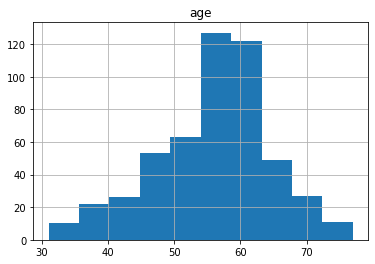

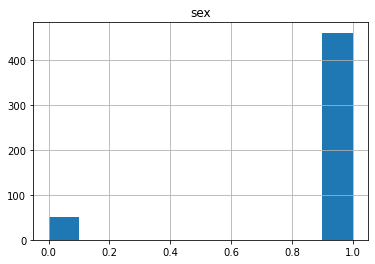

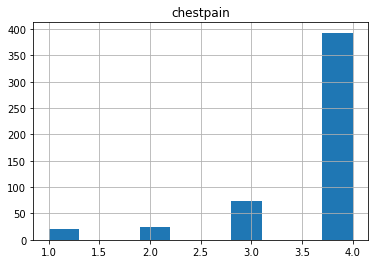

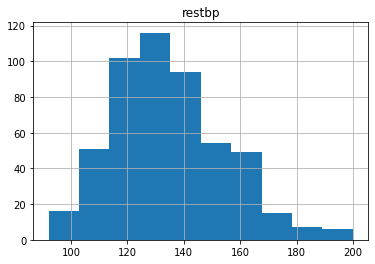

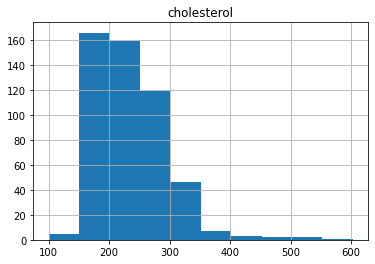

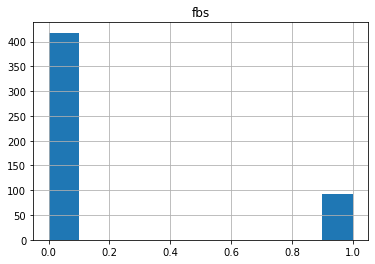

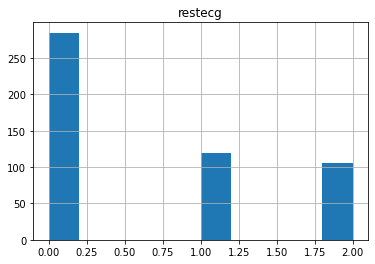

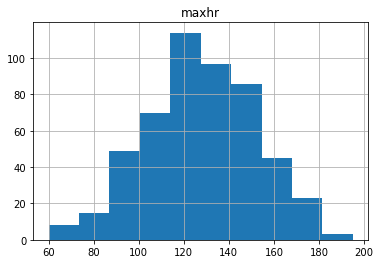

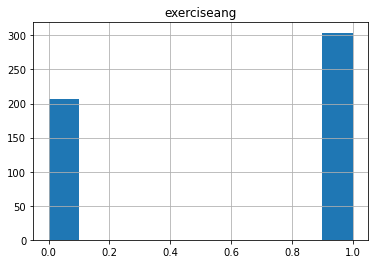

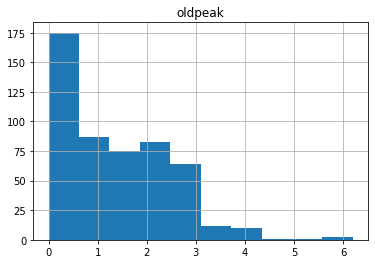

In [894]:
# Create a univariate histogram distribution for healthy and sick patients
# Histogram code sourced from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html

# Filter for healthy and sick classes in frame
healthy_df = combined_df[combined_df['class'] == 0.0]
sick_df = combined_df[combined_df['class'] >= 1.0]

# Print sick distribution
for col in sick_df.columns:
    # Exclude non-numeric variables from distributions
    if col != 'class' and col != 'dataset':
        sick_df.hist(column=col, bins=10);
        

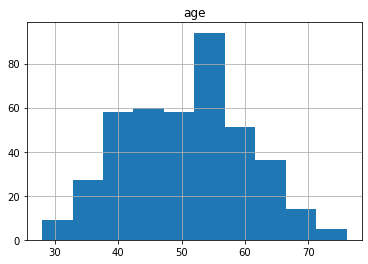

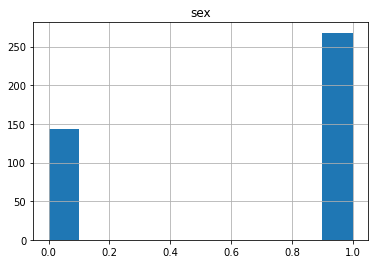

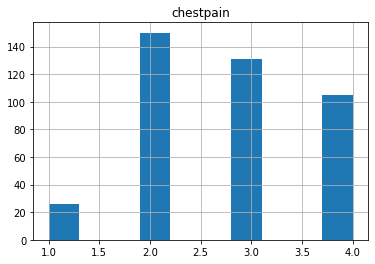

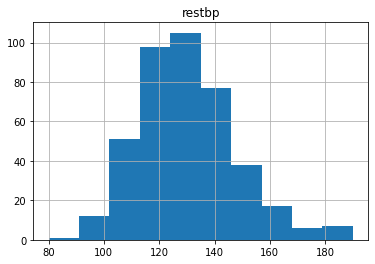

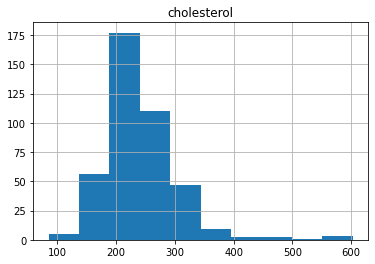

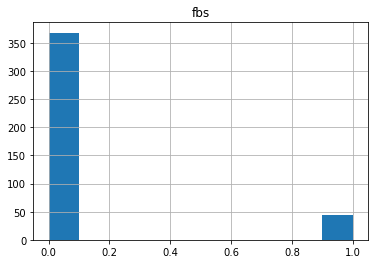

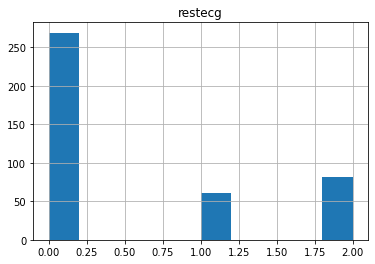

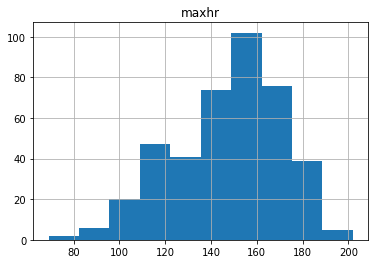

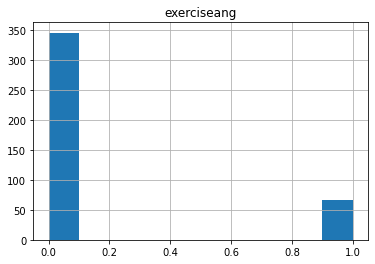

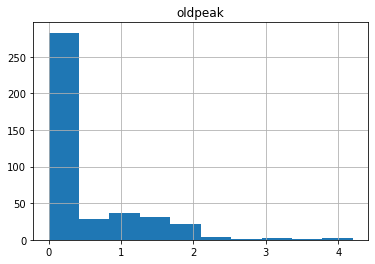

In [895]:
# Print healthy distribution
for col in healthy_df.columns:
    if col != 'class' and col != 'dataset':
        healthy_df.hist(column=col, bins=10);

In [896]:
# Calculate male and female split in overall dataset
print(combined_df['sex'].value_counts())

1.0    728
0.0    194
Name: sex, dtype: int64


                  age       sex  chestpain    restbp  cholesterol       fbs  \
age          1.000000  0.034618  -0.036771  0.095390     0.036264  0.144362   
sex          0.034618  1.000000   0.038542  0.050854    -0.144435 -0.053862   
chestpain   -0.036771  0.038542   1.000000  0.091724     0.087232 -0.039794   
restbp       0.095390  0.050854   0.091724  1.000000     0.098691  0.167925   
cholesterol  0.036264 -0.144435   0.087232  0.098691     1.000000  0.133677   
fbs          0.144362 -0.053862  -0.039794  0.167925     0.133677  1.000000   
restecg      0.003303  0.060933   0.035948  0.055616    -0.055463  0.164040   
maxhr       -0.160667 -0.005723  -0.086087  0.133329    -0.010218  0.036288   
exerciseang  0.096940 -0.010888   0.196391  0.165769     0.064305 -0.177779   
oldpeak      0.098902  0.049159   0.029917  0.145291     0.045328 -0.047965   
class        0.287940  0.147746   0.169205  0.216420     0.092971  0.050683   

              restecg     maxhr  exerciseang   oldp

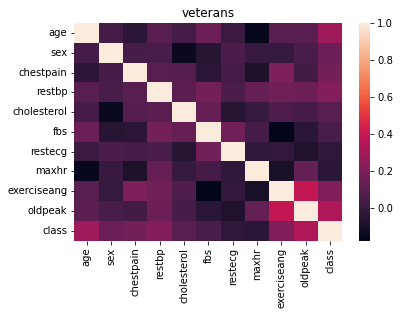

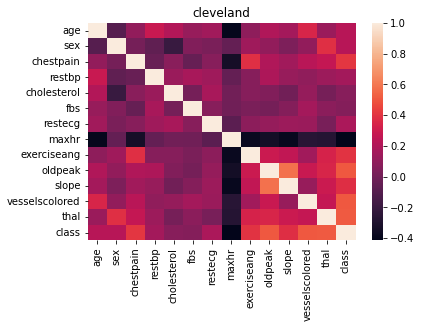

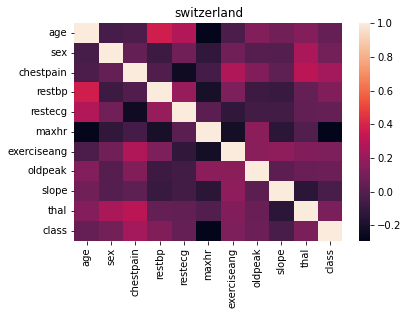

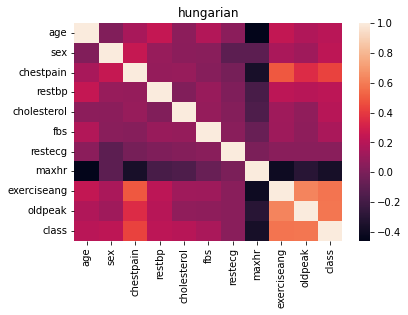

In [897]:
# Generate correlation heat map for all data frame variables
generateHeatMap(stored_frames)

In [898]:
# Generate seperate correlation heat map for the combined data frame
corr_map = combined_df.corr()
print(corr_map)

                  age       sex  chestpain    restbp  cholesterol       fbs  \
age          1.000000  0.057375   0.166869  0.237507     0.013763  0.217732   
sex          0.057375  1.000000   0.171126  0.016523    -0.118618  0.072157   
chestpain    0.166869  0.171126   1.000000  0.032746    -0.021525  0.012426   
restbp       0.237507  0.016523   0.032746  1.000000     0.073568  0.151321   
cholesterol  0.013763 -0.118618  -0.021525  0.073568     1.000000  0.100797   
fbs          0.217732  0.072157   0.012426  0.151321     0.100797  1.000000   
restecg      0.214024 -0.016574   0.032027  0.094973     0.084424  0.148225   
maxhr       -0.370096 -0.188035  -0.324209 -0.088856     0.049633 -0.050659   
exerciseang  0.200572  0.183774   0.397052  0.152290     0.038786  0.052559   
oldpeak      0.251603  0.117511   0.228100  0.149342     0.041443  0.074047   
class        0.280917  0.257850   0.404269  0.178437     0.010322  0.096922   

              restecg     maxhr  exerciseang   oldp

In [899]:
# Binary Classification Task

# Logistic Regression
# Suppoer Vector Classification Linear

In [900]:
# Binary Models, Class is 0 or 1
# Code sourced from https://medium.com/thinkport/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2
# Code sourced from https://www.datasklr.com/logistic-regression/multinomial-logistic-regression

# Format train/test x and y data
binary_x = result.drop(columns='class', axis=1) 

binary_y = result['class']

# Set all classes greater than 1 to 1
binary_y.mask(binary_y == 2, 1, inplace=True)
binary_y.mask(binary_y == 3, 1, inplace=True)
binary_y.mask(binary_y == 4, 1, inplace=True)

btrain_x, btest_x, btrain_y, btest_y = train_test_split(binary_x, binary_y, test_size = 0.20)

print(btrain_x.shape)
print(btest_x.shape)
print(btrain_y.shape)
print(btest_y.shape)

(737, 10)
(185, 10)
(737,)
(185,)


In [901]:
# Code sourced from https://www.datasklr.com/logistic-regression/multinomial-logistic-regression
# Code sourced from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# Code sourced from https://scikit-learn.org/stable/modules/cross_validation.html

binary_logistic_model = linear_model.LogisticRegression().fit(btrain_x, btrain_y)
binary_logistic_preds = binary_logistic_model.predict(btest_x)
print("Logistic regression Train Accuracy :: ", metrics.accuracy_score(btest_y, binary_logistic_preds))

# Perform K=10 cross validation
binary_logistic_scores = cross_val_score(binary_logistic_model, binary_x, binary_y, cv=10)
print("%0.2f Binary Logistic Accuracy with a standard deviation of %0.2f" % (binary_logistic_scores.mean(), binary_logistic_scores.std()))

Logistic regression Train Accuracy ::  0.7621621621621621


/Users/pranavvaranasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pranavvaranasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

0.77 Binary Logistic Accuracy with a standard deviation of 0.07


/Users/pranavvaranasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pranavvaranasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

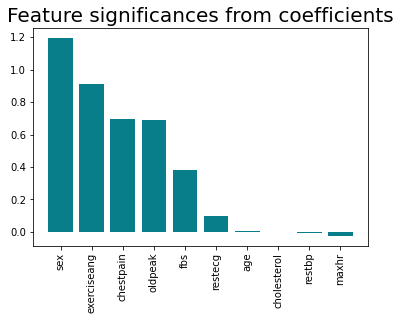

In [902]:
plotPredictors(btrain_x, binary_logistic_model)

In [903]:
# Code sourced from https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.html
# Class values must be 0 and 1 for simple logistic regression
# Print p-values for logistic regression
logit_model= sm.Logit(btrain_y, btrain_x).fit()
summary_model =logit_model.summary()
print(summary_model)

Optimization terminated successfully.
         Current function value: 0.445714
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  737
Model:                          Logit   Df Residuals:                      727
Method:                           MLE   Df Model:                            9
Date:                Mon, 02 May 2022   Pseudo R-squ.:                  0.3533
Time:                        13:59:09   Log-Likelihood:                -328.49
converged:                       True   LL-Null:                       -507.98
Covariance Type:            nonrobust   LLR p-value:                 7.606e-72
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age             0.0031      0.010      0.317      0.751      -0.016       0.022
sex             1.2590    

In [904]:
# Code sourced from https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# Run training for support vector classification

blinear = svm.SVC(kernel='linear').fit(btrain_x, btrain_y)
blinear_preds = blinear.predict(btest_x)
print("Binary SVC Accuracy :: ", metrics.accuracy_score(btest_y, blinear_preds))

# Perform K=10 cross validation
binary_svc_scores = cross_val_score(blinear, binary_x, binary_y, cv=10)
print("%0.2f Binary SVC Linear Accuracy with a standard deviation of %0.2f" % (binary_svc_scores.mean(), binary_svc_scores.std()))


Binary SVC Accuracy ::  0.7945945945945946
0.78 Binary SVC Linear Accuracy with a standard deviation of 0.06


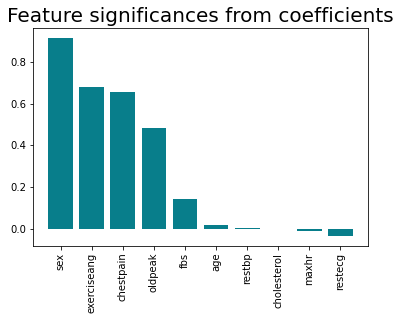

In [905]:
plotPredictors(btrain_x, blinear)

In [906]:
# Multinomial Models, Class is 0 or 1

# Use previous train test format to split data for MN classification
frame_x = result.drop(columns='class', axis=1) 
frame_y = result['class']

train_x, test_x, train_y, test_y = train_test_split(frame_x, frame_y, test_size = 0.20)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)


(737, 10)
(185, 10)
(737,)
(185,)


In [907]:
# Multinomial Logistic Regression Model
# Code sourced from https://www.datasklr.com/logistic-regression/multinomial-logistic-regression
mn_logistic_model = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(train_x, train_y)
mn_logistic_preds = mn_logistic_model.predict(test_x)
print('Accuracy Score:', metrics.accuracy_score(test_y, mn_logistic_preds))  

# Perform K=10 cross validation
mn_logistic_scores = cross_val_score(mn_logistic_model, frame_x, frame_y, cv=10)
print("%0.2f MN Logistic Accuracy with a standard deviation of %0.2f" % (mn_logistic_scores.mean(), mn_logistic_scores.std()))

Accuracy Score: 0.7513513513513513
0.78 MN Logistic Accuracy with a standard deviation of 0.07


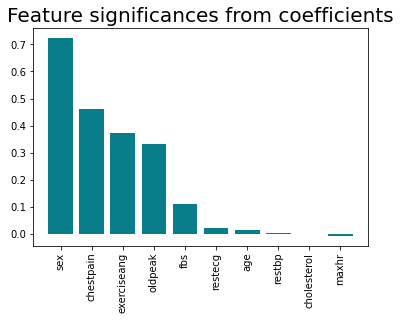

In [908]:
plotPredictors(train_x, mn_logistic_model)

In [909]:
# Code sourced from https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.MNLogit.html
# MN compares base class 0 against everything else to create 4 models for class
mnlogit_model= sm.MNLogit(train_y,sm.add_constant(train_x)).fit()
mnlogit_stats = mnlogit_model.summary()
print(mnlogit_stats)

Optimization terminated successfully.
         Current function value: 0.427224
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                  class   No. Observations:                  737
Model:                        MNLogit   Df Residuals:                      726
Method:                           MLE   Df Model:                           10
Date:                Mon, 02 May 2022   Pseudo R-squ.:                  0.3797
Time:                        13:59:24   Log-Likelihood:                -314.86
converged:                       True   LL-Null:                       -507.61
Covariance Type:            nonrobust   LLR p-value:                 1.143e-76
    class=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.2402      1.371     -3.093      0.002      -6.927      -1.553
age             0.0273    

/Users/pranavvaranasi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [910]:
# Code sourced from https://towardsdatascience.com/multiclass-classification-with-support-vector-machines-svm-kernel-trick-kernel-functions-f9d5377d6f02
mn_svc_model = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(train_x, train_y)
mn_svc_preds = mn_svc_model.predict(test_x)
print("MN SVC Accuracy :: ", metrics.accuracy_score(btest_y, mn_svc_preds))

# Perform K=10 cross validation
mn_svc_scores = cross_val_score(mn_svc_model, frame_x, frame_y, cv=10)
print("%0.2f Multinomial SVC Accuracy with a standard deviation of %0.2f" % (mn_svc_scores.mean(), mn_svc_scores.std()))

MN SVC Accuracy ::  0.5621621621621622
0.78 Multinomial SVC Accuracy with a standard deviation of 0.06


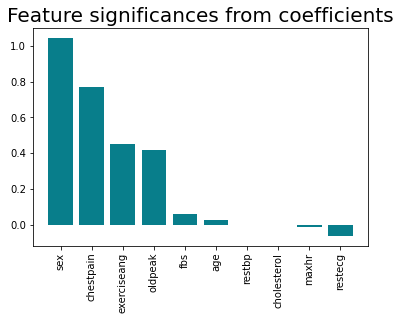

In [911]:
plotPredictors(train_x, mn_svc_model)

In [912]:
# Female tests

# Filter for just female data in frame
female_result = result[result['sex'] == 1.0]

female_x = female_result.drop(columns='class', axis=1) 
female_y = female_result['class']

ftrain_x, ftest_x, ftrain_y, ftest_y = train_test_split(female_x, female_y, test_size = 0.20)

print(ftrain_x.shape)
print(ftest_x.shape)
print(ftrain_y.shape)
print(ftest_y.shape)

(582, 10)
(146, 10)
(582,)
(146,)


In [913]:
# Mask data for binary classification
binary_female_x = female_result.drop(columns='class', axis=1) 
binary_female_y = female_result['class']
binary_female_y.mask(binary_female_y == 2, 1, inplace=True)
binary_female_y.mask(binary_female_y == 3, 1, inplace=True)
binary_female_y.mask(binary_female_y == 4, 1, inplace=True)

bftrain_x, bftest_x, bftrain_y, bftest_y = train_test_split(binary_female_x, binary_female_y, test_size = 0.20)

print(bftrain_x.shape)
print(bftest_x.shape)
print(bftrain_y.shape)
print(bftest_y.shape)

(582, 10)
(146, 10)
(582,)
(146,)


/Users/pranavvaranasi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [914]:
# Peform Binary Female Logistic Regression
binary_female_logistic_model = linear_model.LogisticRegression().fit(bftrain_x, bftrain_y)
binary_female_logistic_preds = binary_female_logistic_model.predict(bftest_x)
print("Female Logistic regression Train Accuracy :: ", metrics.accuracy_score(bftest_y, binary_female_logistic_preds))

# Perform K=10 cross validation
binary_female_logistic_scores = cross_val_score(binary_female_logistic_model, binary_female_x, binary_female_y, cv=10)
print("%0.2f Female Logistic Accuracy with a standard deviation of %0.2f" % (binary_female_logistic_scores.mean(), binary_female_logistic_scores.std()))

Female Logistic regression Train Accuracy ::  0.7534246575342466


/Users/pranavvaranasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pranavvaranasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

0.77 Female Logistic Accuracy with a standard deviation of 0.05


/Users/pranavvaranasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pranavvaranasi/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

In [915]:
# Peform Binary Female Logistic Regression and print p-values with statsmodels
binary_female_logit_model = sm.Logit(bftrain_y, bftrain_x).fit()
binary_female_stats= binary_female_logit_model.summary()
print(binary_female_stats)

Optimization terminated successfully.
         Current function value: 0.448897
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  582
Model:                          Logit   Df Residuals:                      572
Method:                           MLE   Df Model:                            9
Date:                Mon, 02 May 2022   Pseudo R-squ.:                  0.3165
Time:                        13:59:38   Log-Likelihood:                -261.26
converged:                       True   LL-Null:                       -382.25
Covariance Type:            nonrobust   LLR p-value:                 4.919e-47
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age             0.0347      0.014      2.542      0.011       0.008       0.062
sex            -1.8798    

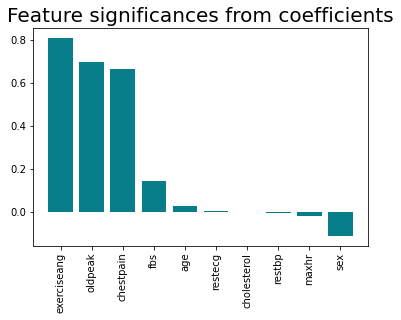

In [916]:
plotPredictors(bftrain_x, binary_female_logistic_model)

In [917]:
# Peform Binary Female SVC
binary_female_linear = svm.SVC(kernel='linear').fit(bftrain_x, bftrain_y)
binary_female_linear_preds = binary_female_linear.predict(bftest_x)
print("Binary Female SVC Accuracy :: ", metrics.accuracy_score(bftest_y, binary_female_linear_preds))

# Perform K=10 cross validation
binary_female_svc_scores = cross_val_score(binary_female_linear, binary_female_x, binary_female_y, cv=10)
print("%0.2f Binary SVC Linear Accuracy with a standard deviation of %0.2f" % (binary_female_svc_scores.mean(), binary_female_svc_scores.std()))


Binary Female SVC Accuracy ::  0.7671232876712328
0.77 Binary SVC Linear Accuracy with a standard deviation of 0.06


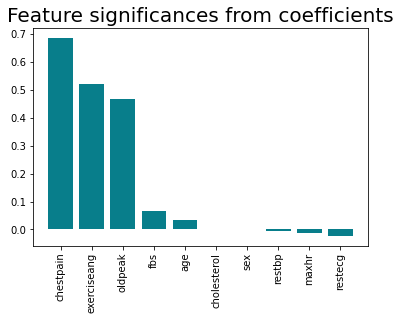

In [918]:
plotPredictors(bftrain_x, binary_female_linear)

In [919]:
# Peform MN Female Logistic Regression
mn_female_logistic_model = LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(ftrain_x, ftrain_y)
mn_female_logistic_preds = mn_female_logistic_model.predict(ftest_x)
print('Accuracy Score:', metrics.accuracy_score(ftest_y, mn_female_logistic_preds))  

# Perform K=10 cross validation
mn_female_logistic_scores = cross_val_score(mn_female_logistic_model, female_x, female_y, cv=10)
print("%0.2f MN Female Logistic Accuracy with a standard deviation of %0.2f" % (mn_female_logistic_scores.mean(), mn_female_logistic_scores.std()))

Accuracy Score: 0.8013698630136986
0.77 MN Female Logistic Accuracy with a standard deviation of 0.05


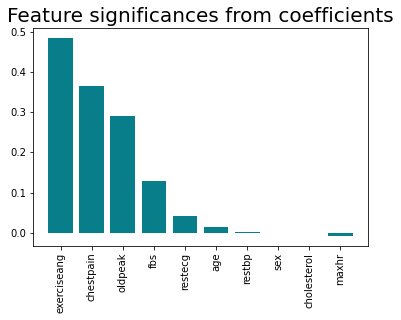

In [920]:
plotPredictors(ftrain_x, mn_female_logistic_model)

In [921]:
# Peform MN Female Logistic Regression and print p-values
mlogit_female_model=sm.MNLogit(ftrain_y,sm.add_constant(ftrain_x)).fit()
stats1_female=mlogit_female_model.summary()
print(stats1_female)

Optimization terminated successfully.
         Current function value: 0.464228
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                  class   No. Observations:                  582
Model:                        MNLogit   Df Residuals:                      572
Method:                           MLE   Df Model:                            9
Date:                Mon, 02 May 2022   Pseudo R-squ.:                  0.2981
Time:                        13:59:50   Log-Likelihood:                -270.18
converged:                       True   LL-Null:                       -384.90
Covariance Type:            nonrobust   LLR p-value:                 2.156e-44
    class=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age             0.0304      0.014      2.182      0.029       0.003       0.058
sex            -2.1622    

/Users/pranavvaranasi/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [922]:
# Peform MN Female SVC
mn_female_svc_model = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(ftrain_x, ftrain_y)
mn_female_svc_preds = mn_female_svc_model.predict(ftest_x)
print("MN Female SVC Accuracy :: ", metrics.accuracy_score(ftest_y, mn_female_svc_preds))

# Perform K=10 cross validation
mn_female_svc_scores = cross_val_score(mn_female_svc_model, female_x, female_y, cv=10)
print("%0.2f Multinomial SVC Accuracy with a standard deviation of %0.2f" % (mn_female_svc_scores.mean(), mn_female_svc_scores.std()))

MN Female SVC Accuracy ::  0.815068493150685
0.77 Multinomial SVC Accuracy with a standard deviation of 0.06


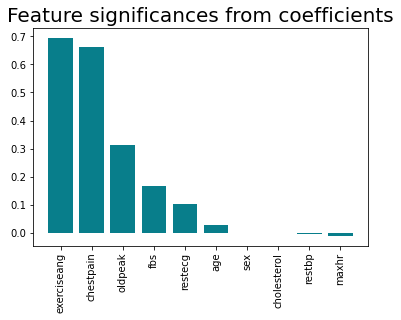

In [923]:
plotPredictors(ftrain_x, mn_female_svc_model)